# Assignment 2 - EDA

In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')


In [2]:
!pip install pyspark==2.3.0

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 211.9 MB 65 kB/s s eta 0:00:016��████▊                       | 58.1 MB 7.2 MB/s eta 0:00:22          | 95.7 MB 7.4 MB/s eta 0:00:16��███████▍              | 115.1 MB 9.6 MB/s eta 0:00:11     |████████████████████████████▉   | 191.2 MB 7.5 MB/s eta 0:00:03
     |████████████████████████████████| 189 kB 30.1 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-2.3.0-py2.py3-none-any.whl size=212271916 sha256=c65180905b550524c17c9cfe25a035a24bed3128df0c32806fcb92489c90dca6
  Stored in directory

In [3]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [4]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

## 1. Functions for describing statistical measures (moments) 

1. Function returning the number of rows in the dataframe

In [5]:
def count(dataframe):
    return spark.sql('select count(*) as cnt from washing').first().cnt

2.  Function returning the number of fields (columns) and a list the field names in this data frame

In [6]:
def getNumberOfFields(dataframe):
    return len(dataframe.columns)

def getFieldNames(dataframe):
    return dataframe.columns

3. Function returning the minimal temperature for the test data set

In [7]:
def minTemperature(df):
    return spark.sql("SELECT MIN(temperature) AS mintemp FROM washing").first().mintemp

def maxTemperature(df):
    return spark.sql("SELECT MAX(temperature) AS maxtemp FROM washing").first().maxtemp

4. Function returning the mean and the standard deviation of the temperature

In [8]:
def meanTemperature(df):
    return spark.sql("SELECT AVG(temperature) AS meantemp FROM washing").first().meantemp

def sdTemperature(df):
    return spark.sql("SELECT STDDEV(temperature) AS sdtemp FROM washing").first().sdtemp

5. Function returning the skew and the kurtosis of the temperature

In [9]:
def skewTemperature(df):    
    return spark.sql("""
    SELECT 
    (
        COUNT(temperature)*1.0 / ((COUNT(temperature)-1) * (COUNT(temperature)-2))
    ) *
    SUM (
        POWER(temperature-%s,3)/POWER(%s,3)
        )
    AS sktemperature FROM washing
                    """ %(meanTemperature(df),sdTemperature(df))).first().sktemperature


def kurtosisTemperature(df):    
        return spark.sql("""
SELECT 
    (
        (COUNT(temperature)+1) / ((COUNT(temperature)-1) * (COUNT(temperature)-2)* (COUNT(temperature)-3))
    ) *
    SUM (
        POWER(temperature-%s,4)/POWER(%s,4)
    )
AS ktemperature FROM washing
                    """ %(meanTemperature(df),sdTemperature(df))).first().ktemperature

6. Function returning the correlation of the temperature and the hardness

In [10]:
def correlationTemperatureHardness(df):
    return spark.sql("SELECT CORR(temperature,hardness) as temperaturehardness from washing").first().temperaturehardness

## 2. Functions for EDA

1. Function returning a 10% sample of a given data frame

In [11]:
def getSample(df,spark):
    return df.rdd.sample(False,0.1)

2. Function visualizing a list containing all temperature values from the data set

In [12]:
def getListForHistogramAndBoxPlot(df,spark):
    my_list = spark.sql("""
        SELECT temperature FROM washing WHERE temperature is not null
    """).rdd.map(lambda row: row.temperature).collect()
    if not type(my_list)==list:
        raise Exception('return type not a list')
    return my_list

3. Function visualizing two lists (encapsulated in a python tuple object) containing temperature and timestamp (ts) ordered by timestamp

In [13]:
 def getListsForRunChart(df,spark):
    double_tuple_rdd = spark.sql("""
        SELECT temperature, ts  FROM washing WHERE temperature is not null ORDER BY ts ASC
    """).sample(False,0.1).rdd.map(lambda row : (row.ts,row.temperature))
    result_array_ts = double_tuple_rdd.map(lambda ts_temperature: ts_temperature[0]).collect()
    result_array_temperature = double_tuple_rdd.map(lambda ts_temperature: ts_temperature[1]).collect()
    return (result_array_ts,result_array_temperature)

## 3. Grabbing PARQUET file and create a dataframe out of it, using SparkSQL 

In [14]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2021-10-17 16:54:58--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/claimed/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2021-10-17 16:54:58--  https://github.com/IBM/claimed/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/claimed/raw/master/coursera_ds/washing.parquet [following]
--2021-10-17 16:54:59--  https://github.com/IBM/claimed/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/claimed/master/coursera_ds/washing.parquet [following]
--2021-10-17 16:54:59

In [15]:
df = spark.read.parquet('washing.parquet')
df.createOrReplaceTempView('washing')
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

## 4. Testing functions for describing statistical measures (moments) 

1. Test count function

In [16]:
cnt = None
nof = None
fn = None

cnt = count(df)
print(cnt)

2058


2.1 Test getNumberOfFields function

In [17]:
nof = getNumberOfFields(df)
print(nof)

11


2.2 Test your getFieldNames function

In [18]:
fn = getFieldNames(df)
print(fn)

['_id', '_rev', 'count', 'flowrate', 'fluidlevel', 'frequency', 'hardness', 'speed', 'temperature', 'ts', 'voltage']


In [19]:
min_temperature = 0
mean_temperature = 0
max_temperature = 0
sd_temperature = 0
skew_temperature = 0
kurtosis_temperature = 0
correlation_temperature = 0

3.1 Test minTemperature function

In [20]:
min_temperature = minTemperature(df)
print(min_temperature)

80


3.2 Test maxTemperature function

In [21]:
max_temperature = maxTemperature(df)
print(max_temperature)

100


4.1 Test meanTemperature function

In [22]:
mean_temperature = meanTemperature(df)
print(mean_temperature)

90.03800298062593


4.2 Test sdTemperature function

In [23]:
sd_temperature = sdTemperature(df)
print(sd_temperature)

6.1007610586219725


5.1 Test skewTemperature function

In [24]:
skew_temperature = skewTemperature(df)
print(skew_temperature)

0.01042166031314543


5.2 Test kurtosisTemperature function

In [25]:
kurtosis_temperature = kurtosisTemperature(df)
print(kurtosis_temperature)

0.0013283965176234397


6. Test correlationTemperatureHardness function

In [26]:
correlation_temperature = correlationTemperatureHardness(df)
print(correlation_temperature)

0.017754069047296324


## 4. Testing functions for EDA

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

1. Test getSample function

In [28]:
def getSample(df,spark):
    return df.rdd.sample(False,0.1)

2. Plot getListForHistogramAndBoxPlot function

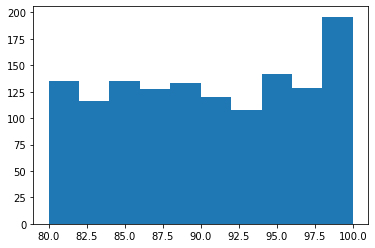

In [29]:
plt.hist(getListForHistogramAndBoxPlot(df,spark))
plt.show()

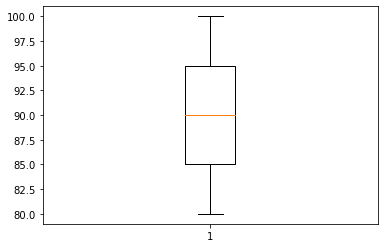

In [30]:
plt.boxplot(getListForHistogramAndBoxPlot(df,spark))
plt.show()

3. Plot getListsForRunChart function

In [31]:
lists = getListsForRunChart(df, spark)

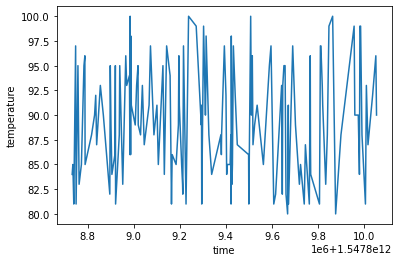

In [32]:
plt.plot(lists[0],lists[1])
plt.xlabel("time")
plt.ylabel("temperature")
plt.show()